## Cluster Analysis
This book comprises a cluster analyis of the complete dataset (original) and its derived datasets (Influencers_OLS, OLS_all and uniques23 and uniques23_50), as defined in earlier notebooks. The pipeline applied is described below:

__Data Preparation:__  
    Only scaling and normalization were applied, as data cleaning was already performed in earlier steps.  
__Dimensionality Reduction:__  
    Principal Component Analysis (PCA) was used to reduce dimensionality while retaining approximately 90% of the variance.  
    This step resulted in transformed datasets with reduced feature dimensions, which were subsequently used for clustering.  
__Clustering Analysis:__  
    Clustering was performed on the transformed datasets using:   
    K-Means, with k=5 determined by the elbow method.  
    DBSCAN, for detecting clusters and outliers.  
    Gaussian Mixture Models (GMM), to capture potential non-linear structures.  
__Performance evaluation included:__   
    Internal metrics, such as Silhouette Score and Davies-Bouldin Index.  
    External metrics (where labels were available), including Adjusted Rand Index (ARI) and Homogeneity Score.  

In [183]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import adjusted_rand_score
from umap import UMAP
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

MinMaxScaler is the denominated scaler that owe to be used with this data since doesnt have gaussian distribution, however it does only work well for DBSCAN, so the StandarScaler is use in conjuction with the KMeans cluster analysis. First pipeline Scales, and reduce the dimensionality with PCA to 90% varianza, then uses 3 clustering methods( K-Means, DBSCAN, and GMM) applied on PCA-reduced data. Evaluation of the methods uses following metrics: Silhouette Score and Davies-Bouldin Index for internal evaluation. Adjusted Rand Index (ARI) for external evaluation since true labels are present.

In [184]:
#Loading the data 
pd.options.display.float_format = '{:.4f}'.format
# Read the excel file
Jointax = pd.read_excel('data/Jointax.xlsx', sheet_name='Biotot_jointax', header=[0,1,2,3,4,5,6,7] , dtype={**{i: str for i in range(0,2)},
                                                                        **{i:float for i in range(2, 884)}},  skiprows=[8]) # Somehow it was showing an empty row, so skiprow deletes it
original_pca   = pd.read_excel(f'data/df_after_pca.xlsx', sheet_name='original_pca')

Influencers_uniques   = pd.read_excel(f'data/df_after_pca.xlsx', sheet_name='Influencers_uniques')

combined   = pd.read_excel(f'data/df_after_pca.xlsx', sheet_name='merged_df')

OLS_all = pd.read_excel('data/OLS_all.xlsx', dtype={**{i: str for i in range(0,2)},
                                            **{i:float for i in range(2, -1)}}) 
Influencers_OLS = pd.read_excel('data/Influencers_OLS.xlsx', dtype={**{i: str for i in range(0,2)},
                                            **{i:float for i in range(2, -1)}})

In [185]:
# Making sure the sites and categories get read as they should
Jointax["Sites"]= Jointax["Sites"].astype(str)
Jointax["Category"]= Jointax["Category"].values.astype(int)
#Drop level of Kindom since it is boring
Jointax.columns = Jointax.columns.droplevel(1)
Jointax = Jointax.reset_index(drop=True)
#Setting the sites as index
Jointax = Jointax.set_index("Sites").reset_index()
# Deleting headers names of unnamed levels
Jointax.columns = Jointax.columns.map(lambda x: tuple('' if 'Unnamed' in str(level) else level for level in x))
#Drop column 1
Jointax =Jointax.drop(Jointax.columns[1], axis=1)
#Correcting the Tuple-like Index
Jointax['Sites'] = Jointax['Sites'].map(lambda x: x[0] if isinstance(x, tuple) else x)
Jointax = Jointax.set_index("Sites")

In [186]:
# We working only with the values in this notebook, still keeping the taxa 
Jointax.columns = Jointax.columns.droplevel([0,1,2,3,4,5])
original = Jointax.reset_index(drop=False)
#Reset the index
if original.columns[1] == "":
    original.rename(columns = {original.columns[1]: "Category"}, inplace=True)
original= original.set_index("Sites")

In [187]:
def clean_dataframe(df):
    # Check if 'Unnamed: 0' exists before dropping
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns='Unnamed: 0', axis=1)
    return df.astype({'Sites': str, 'Category': int}).set_index("Sites")

OLS_all = clean_dataframe(OLS_all)
Influencers_OLS = clean_dataframe(Influencers_OLS)
Influencers_uniques = clean_dataframe(Influencers_uniques)
combined= clean_dataframe(combined)
original_pca = clean_dataframe(original_pca)

In [188]:
def clustering_pipeline_all(df, pca_data_name='pca_data', n_clusters=5, eps=0.5, min_samples=5, n_components=2):
    """
    Performs clustering using K-Means, DBSCAN, and GMM with PCA for dimensionality reduction.
    
    Parameters:
    - df: Input DataFrame (features only, no labels).
    - n_clusters: Number of clusters for K-Means and GMM (default=5).
    - eps: DBSCAN's epsilon parameter (default=0.5).
    - min_samples: Minimum samples for DBSCAN (default=5).
    - n_components: Number of components for PCA (default=2).
    
    Returns:
    - results: Dictionary with clustering results for K-Means, DBSCAN, and GMM, as well as PCA data and metrics.
    """
    results = {}
    # Separate true labels
    true_labels = df['Category']

    df = df.drop(columns=['Category'])  # Drop any non-numeric columns

    # Step 1: Scaling the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)
    
    # Step 2: PCA for dimensionality reduction
    pca = PCA(n_components=n_components)
    pca_data = pca.fit_transform(scaled_data)

    # Calculate explained variance and cumulative variance
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

    # Clustering
    results = {
        'pca': pca,
        'pca_data_name': pca_data,
        'scaled_data': scaled_data,
        'explained_variance': explained_variance_ratio,
        'cumulative_variance': cumulative_variance_ratio
    }

    # Step 3: K-Means Clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(pca_data)
    kmeans_silhouette = silhouette_score(pca_data, kmeans_labels)
    kmeans_db_score = davies_bouldin_score(pca_data, kmeans_labels)
    kmeans_ari = adjusted_rand_score(true_labels, kmeans_labels)

    results['kmeans'] = {
        'cluster_labels': kmeans_labels,
        'silhouette_score': kmeans_silhouette,
        'davies_bouldin_score': kmeans_db_score,
        'adjusted_rand_score': kmeans_ari
    }
    
    # Step 4: DBSCAN Clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_labels = dbscan.fit_predict(pca_data)
    valid_indices = dbscan_labels != -1
    if len(set(dbscan_labels[valid_indices])) > 1:
        dbscan_silhouette = silhouette_score(pca_data[valid_indices], dbscan_labels[valid_indices])
        dbscan_db_score = davies_bouldin_score(pca_data[valid_indices], dbscan_labels[valid_indices])
    else:
        dbscan_silhouette = None
        dbscan_db_score = None
    dbscan_ari = adjusted_rand_score(true_labels, dbscan_labels)

    results['dbscan'] = {
        'cluster_labels': dbscan_labels,
        'silhouette_score': dbscan_silhouette,
        'davies_bouldin_score': dbscan_db_score,
        'adjusted_rand_score': dbscan_ari
    }
    
    # Step 5: GMM Clustering
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm_labels = gmm.fit_predict(pca_data)
    gmm_silhouette = silhouette_score(pca_data, gmm_labels)
    gmm_db_score = davies_bouldin_score(pca_data, gmm_labels)
    gmm_ari = adjusted_rand_score(true_labels, gmm_labels)
    
    results['gmm'] = {
        'cluster_labels': gmm_labels,
        'silhouette_score': gmm_silhouette,
        'davies_bouldin_score': gmm_db_score,
        'adjusted_rand_score': gmm_ari
    }

    # Store PCA-transformed data with the specified name
    results[pca_data_name] = pca_data
    
    return results

## Visualisation K-means, DBSCAN AND GaussianMixture

In [189]:
def visualize_clustering_results(results, title_prefix=''):
    """
    Visualize clustering results with multiple plots and metrics
    
    Parameters:
    - results: Dictionary containing clustering results from clustering_pipeline_all function
    - title_prefix: Optional prefix for plot titles
    """
    # Extract PCA data
    pca_data = results[list(filter(lambda x: x.startswith('pca_'), results.keys()))[0]]
    
    # Create a figure with multiple subplots
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'{title_prefix}Clustering Results Visualization', fontsize=16)
    
    # Color palettes for different clustering methods
    color_palettes = [
        sns.color_palette("husl", n_colors=len(np.unique(results['kmeans']['cluster_labels']))),
        sns.color_palette("seismic", n_colors=len(np.unique(results['dbscan']['cluster_labels']))),
        sns.color_palette("deep", n_colors=len(np.unique(results['gmm']['cluster_labels'])))
    ]
    
    # Clustering methods and their labels
    clustering_methods = [
        ('K-Means', results['kmeans']['cluster_labels'], color_palettes[0]),
        ('DBSCAN', results['dbscan']['cluster_labels'], color_palettes[1]),
        ('Gaussian Mixture Model', results['gmm']['cluster_labels'], color_palettes[2])
    ]
    
    # Scatter plots for each clustering method
    for idx, (method_name, labels, color_palette) in enumerate(clustering_methods):
        row = idx // 2
        col = idx % 2
        
        # Handle DBSCAN noise points
        if method_name == 'DBSCAN':
            noise_mask = labels == -1
            cluster_mask = labels != -1
            
            # Plot noise points
            if np.any(noise_mask):
                axs[row, col].scatter(
                    pca_data[noise_mask, 0], 
                    pca_data[noise_mask, 1], 
                    c='gray', 
                    alpha=0.5, 
                    label='Noise'
                )
            
            # Plot clustered points
            unique_labels = np.unique(labels[cluster_mask])
            for label in unique_labels:
                mask = (labels == label) & cluster_mask
                axs[row, col].scatter(
                    pca_data[mask, 0], 
                    pca_data[mask, 1], 
                    c=[color_palette[label]], 
                    label=f'Cluster {label}'
                )
        else:
            # For K-Means and GMM
            unique_labels = np.unique(labels)
            for label in unique_labels:
                mask = labels == label
                axs[row, col].scatter(
                    pca_data[mask, 0], 
                    pca_data[mask, 1], 
                    c=[color_palette[label]], 
                    label=f'Cluster {label}'
                )
        
        axs[row, col].set_title(f'{method_name} Clustering')
        axs[row, col].set_xlabel('First Principal Component')
        axs[row, col].set_ylabel('Second Principal Component')
        axs[row, col].legend()
    
    plt.tight_layout()
    plt.show()

def print_clustering_metrics(results):
    """
    Print detailed clustering metrics for each method
    
    Parameters:
    - results: Dictionary containing clustering results
    """
    print("\n=== Clustering Metrics ===")
    
    # Metrics for each clustering method
    clustering_methods = ['kmeans', 'dbscan', 'gmm']
    
    for method in clustering_methods:
        print(f"\n{method.upper()} Clustering Metrics:")
        silhouette = results[method]['silhouette_score']
        db_score = results[method]['davies_bouldin_score']
        ari = results[method].get('adjusted_rand_score', 'N/A')  # Use 'N/A' if ARI is not available

        print(f"Silhouette Score: {silhouette if silhouette is not None else 'Not applicable'}")
        print(f"Davies-Bouldin Score: {db_score if db_score is not None else 'Not applicable'}")
        print(f"Adjusted Rand Score: {ari}")
        
        # Count cluster sizes
        labels = results[method]['cluster_labels']
        if method == 'dbscan':
            valid_labels = labels[labels != -1]
            unique_labels = np.unique(valid_labels)
        else:
            unique_labels = np.unique(labels)
        
        print("\nCluster Sizes:")
        for label in unique_labels:
            if method == 'dbscan' and label == -1:
                count = np.sum(labels == label)
                print(f"Noise Points: {count}")
            else:
                count = np.sum(labels == label)
                print(f"Cluster {label}: {count} points")
    
    # Print Explained Variance for PCA
    print("\nPCA Explained Variance Ratio:")
    explained_variance = results['explained_variance']
    for i, var in enumerate(explained_variance[:10], 1):
        print(f"PC{i}: {var * 100:.2f}%")
    print(f"Total Variance Explained (first 10 PCs): {np.sum(explained_variance[:10]) * 100:.2f}%")

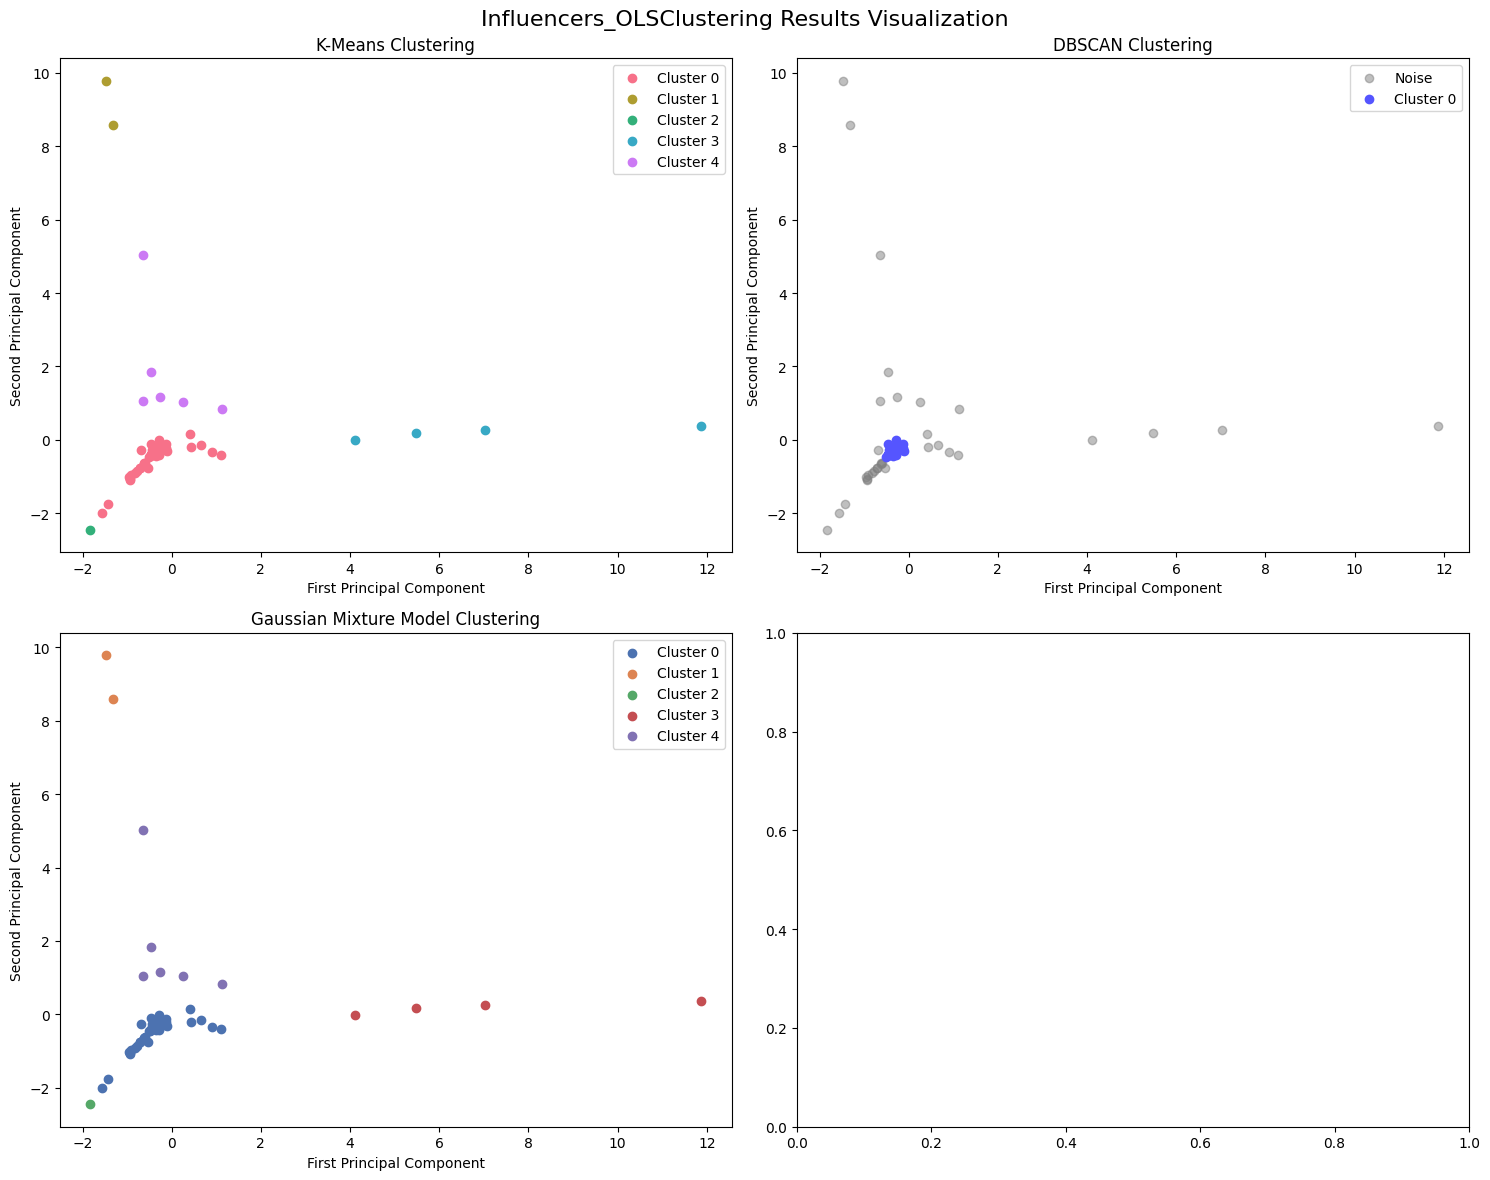


=== Clustering Metrics ===

KMEANS Clustering Metrics:
Silhouette Score: 0.648375314612715
Davies-Bouldin Score: 0.5160419399380063
Adjusted Rand Score: 0.18453461053893616

Cluster Sizes:
Cluster 0: 57 points
Cluster 1: 2 points
Cluster 2: 1 points
Cluster 3: 4 points
Cluster 4: 6 points

DBSCAN Clustering Metrics:
Silhouette Score: Not applicable
Davies-Bouldin Score: Not applicable
Adjusted Rand Score: 0.1158484972356072

Cluster Sizes:
Cluster 0: 37 points

GMM Clustering Metrics:
Silhouette Score: 0.648375314612715
Davies-Bouldin Score: 0.5160419399380063
Adjusted Rand Score: 0.18453461053893616

Cluster Sizes:
Cluster 0: 57 points
Cluster 1: 2 points
Cluster 2: 1 points
Cluster 3: 4 points
Cluster 4: 6 points

PCA Explained Variance Ratio:
PC1: 19.12%
PC2: 16.41%
PC3: 10.92%
PC4: 9.15%
PC5: 6.73%
Total Variance Explained (first 10 PCs): 62.33%


In [190]:
# Running pipeline 
results_Influencers_OLS = clustering_pipeline_all(Influencers_OLS,  pca_data_name='pca_data_Influencers_OLS', 
                                                   n_clusters=5, eps=0.5, min_samples=5, n_components=5)
#Calling the function for visualisation
visualize_clustering_results(results_Influencers_OLS, title_prefix='Influencers_OLS')
print_clustering_metrics(results_Influencers_OLS)

influencers_OLS:
K-means: Silhouette Score of 0.603, Davies-Bouldin of 0.552
Very imbalanced cluster sizes (1, 53, 3, 3, 10 points)
PCA explains 35.53% of variance

Notice that for PCA visualisation on notebook PCA_RF_FImporance.ipnyb, the same dataset was used, hower the main difference is that there the category label was use to color code the samples, however category was droped and didnt participate on the clustering, it was used just for color coding.
Plots show similar behaviour because the clustering algorithms (K-Means, DBSCAN, GMM) are able to identify the inherent structure in the data and recover groupings that are consistent with the original category information, even though the category column is not provided. it means the clustering methods are effectively capturing the underlying patterns in the data, regardless of whether the category information is explicitly given or not. The consistency between the PCA visualization and the clustering results indicates the data has a clear structure that the algorithms can latch onto.

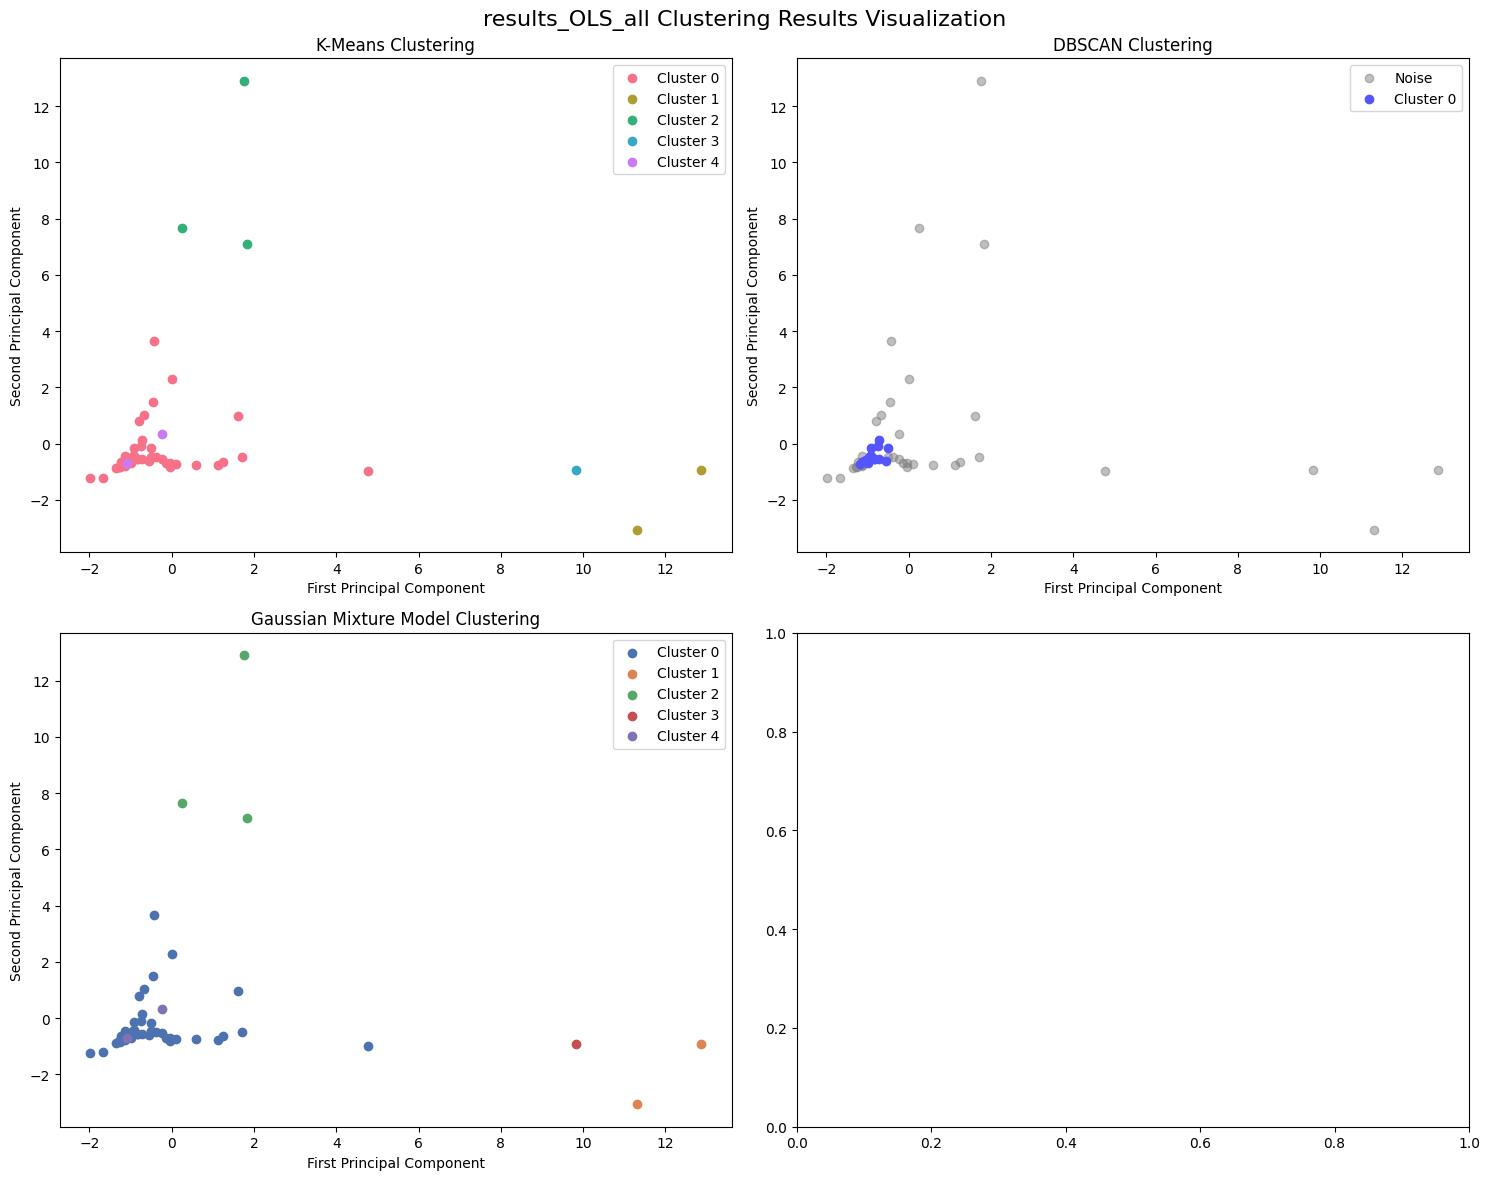


=== Clustering Metrics ===

KMEANS Clustering Metrics:
Silhouette Score: 0.7275569775743765
Davies-Bouldin Score: 0.39104114073843355
Adjusted Rand Score: 0.12140880609088245

Cluster Sizes:
Cluster 0: 62 points
Cluster 1: 2 points
Cluster 2: 3 points
Cluster 3: 1 points
Cluster 4: 2 points

DBSCAN Clustering Metrics:
Silhouette Score: Not applicable
Davies-Bouldin Score: Not applicable
Adjusted Rand Score: 0.11662166071945221

Cluster Sizes:
Cluster 0: 35 points

GMM Clustering Metrics:
Silhouette Score: 0.7275569775743765
Davies-Bouldin Score: 0.39104114073843355
Adjusted Rand Score: 0.12140880609088245

Cluster Sizes:
Cluster 0: 62 points
Cluster 1: 2 points
Cluster 2: 3 points
Cluster 3: 1 points
Cluster 4: 2 points

PCA Explained Variance Ratio:
PC1: 21.35%
PC2: 14.84%
PC3: 10.66%
PC4: 8.53%
PC5: 6.63%
Total Variance Explained (first 10 PCs): 62.01%


In [191]:
# Running pipeline 
results_OLS_all = clustering_pipeline_all(OLS_all,  pca_data_name='pca_data_OLS_all',  n_clusters=5, eps=0.5, min_samples=5, n_components=5)
#Calling the function for visualisation
visualize_clustering_results(results_OLS_all, title_prefix='results_OLS_all ')
print_clustering_metrics(results_OLS_all)

OLS_all
K-means: Silhouette Score of 0.678, Davies-Bouldin of 0.457
Cluster sizes imbalanced (57, 3, 1, 3, 6 points)
PCA explains 36.18% of variance

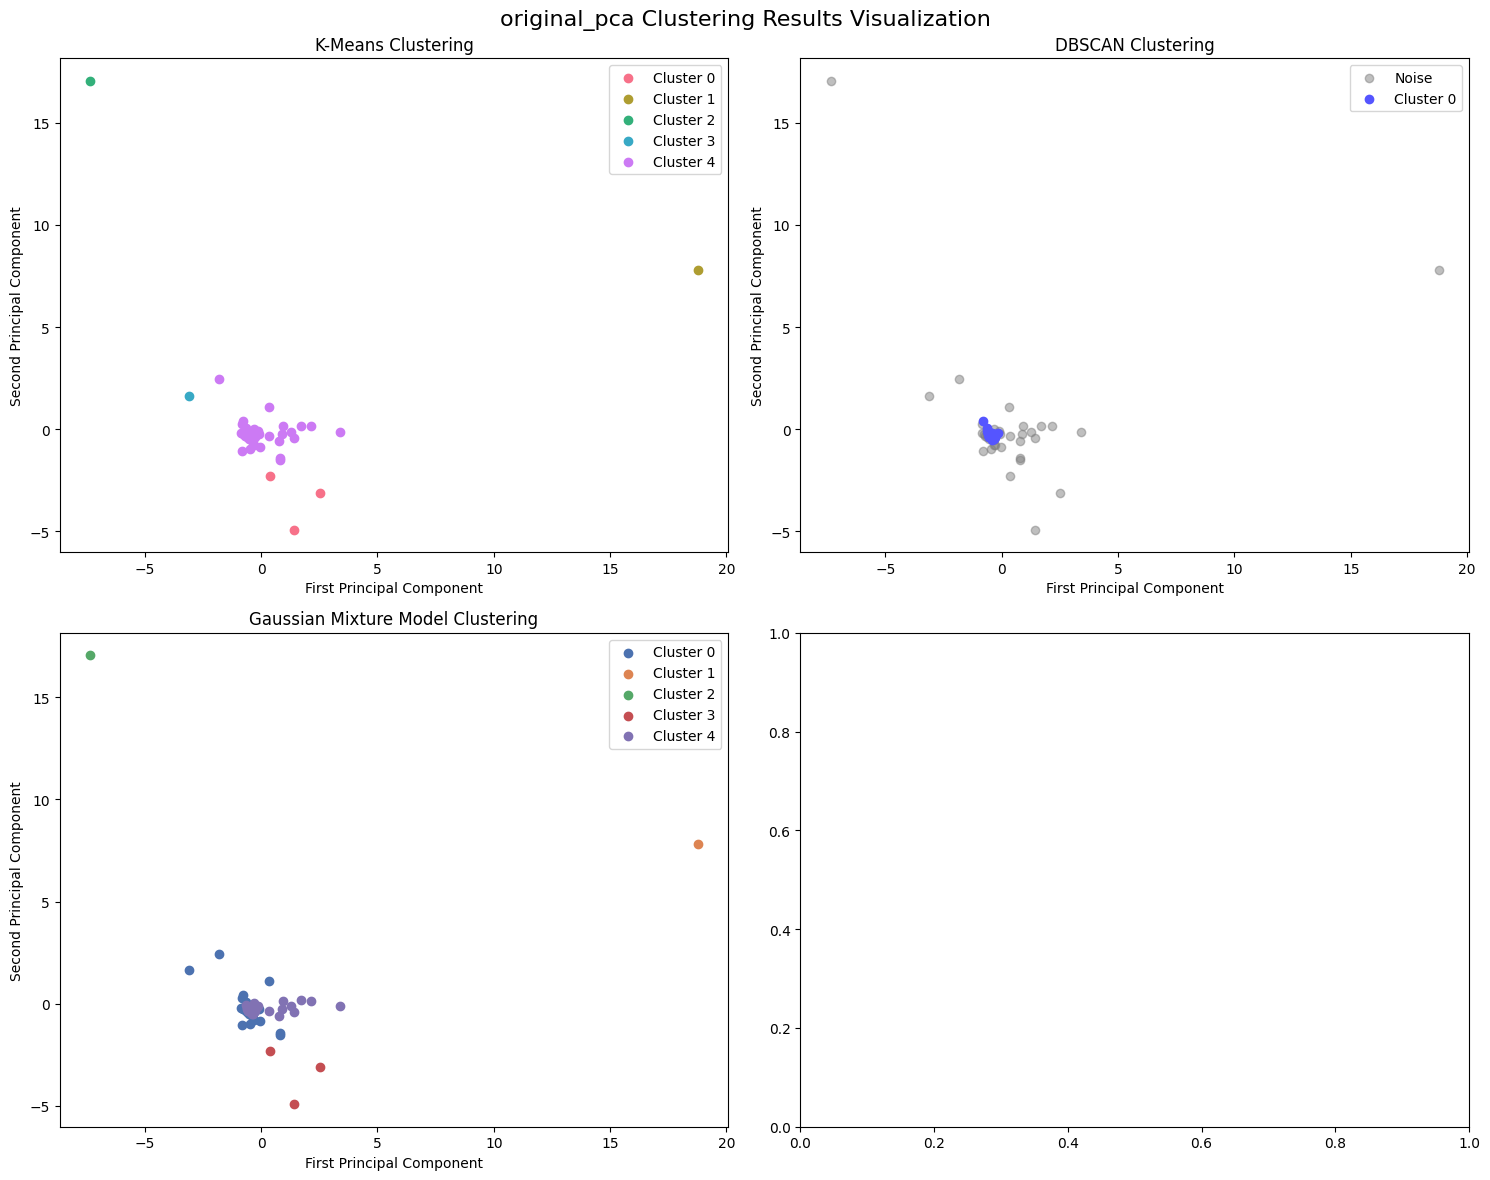


=== Clustering Metrics ===

KMEANS Clustering Metrics:
Silhouette Score: 0.709846411711427
Davies-Bouldin Score: 0.35817111630926607
Adjusted Rand Score: -0.00816568684693526

Cluster Sizes:
Cluster 0: 3 points
Cluster 1: 1 points
Cluster 2: 1 points
Cluster 3: 1 points
Cluster 4: 64 points

DBSCAN Clustering Metrics:
Silhouette Score: Not applicable
Davies-Bouldin Score: Not applicable
Adjusted Rand Score: 0.05673160381907609

Cluster Sizes:
Cluster 0: 35 points

GMM Clustering Metrics:
Silhouette Score: 0.19942185250405167
Davies-Bouldin Score: 1.143204243603245
Adjusted Rand Score: 0.009408718983640516

Cluster Sizes:
Cluster 0: 22 points
Cluster 1: 1 points
Cluster 2: 1 points
Cluster 3: 3 points
Cluster 4: 43 points

PCA Explained Variance Ratio:
PC1: 13.40%
PC2: 11.84%
PC3: 10.09%
PC4: 9.15%
PC5: 8.10%
Total Variance Explained (first 10 PCs): 52.57%


In [192]:
# Running pipeline 
results_original_pca  = clustering_pipeline_all(original_pca,  pca_data_name='pca_data_original_pca ', 
                                                  n_clusters=5, eps=0.5, min_samples=5, n_components=5)
#Calling the function for visualisation
visualize_clustering_results(results_original_pca, title_prefix='original_pca ')
print_clustering_metrics(results_original_pca )

uniques_23_OLS (300+ features):
K-means: Silhouette Score of 0.685, Davies-Bouldin of 0.514
Cluster sizes are quite imbalanced (53, 3, 3, 5, 6 points)
PCA explains 37% of variance (19.95% PC1, 17.05% PC2)

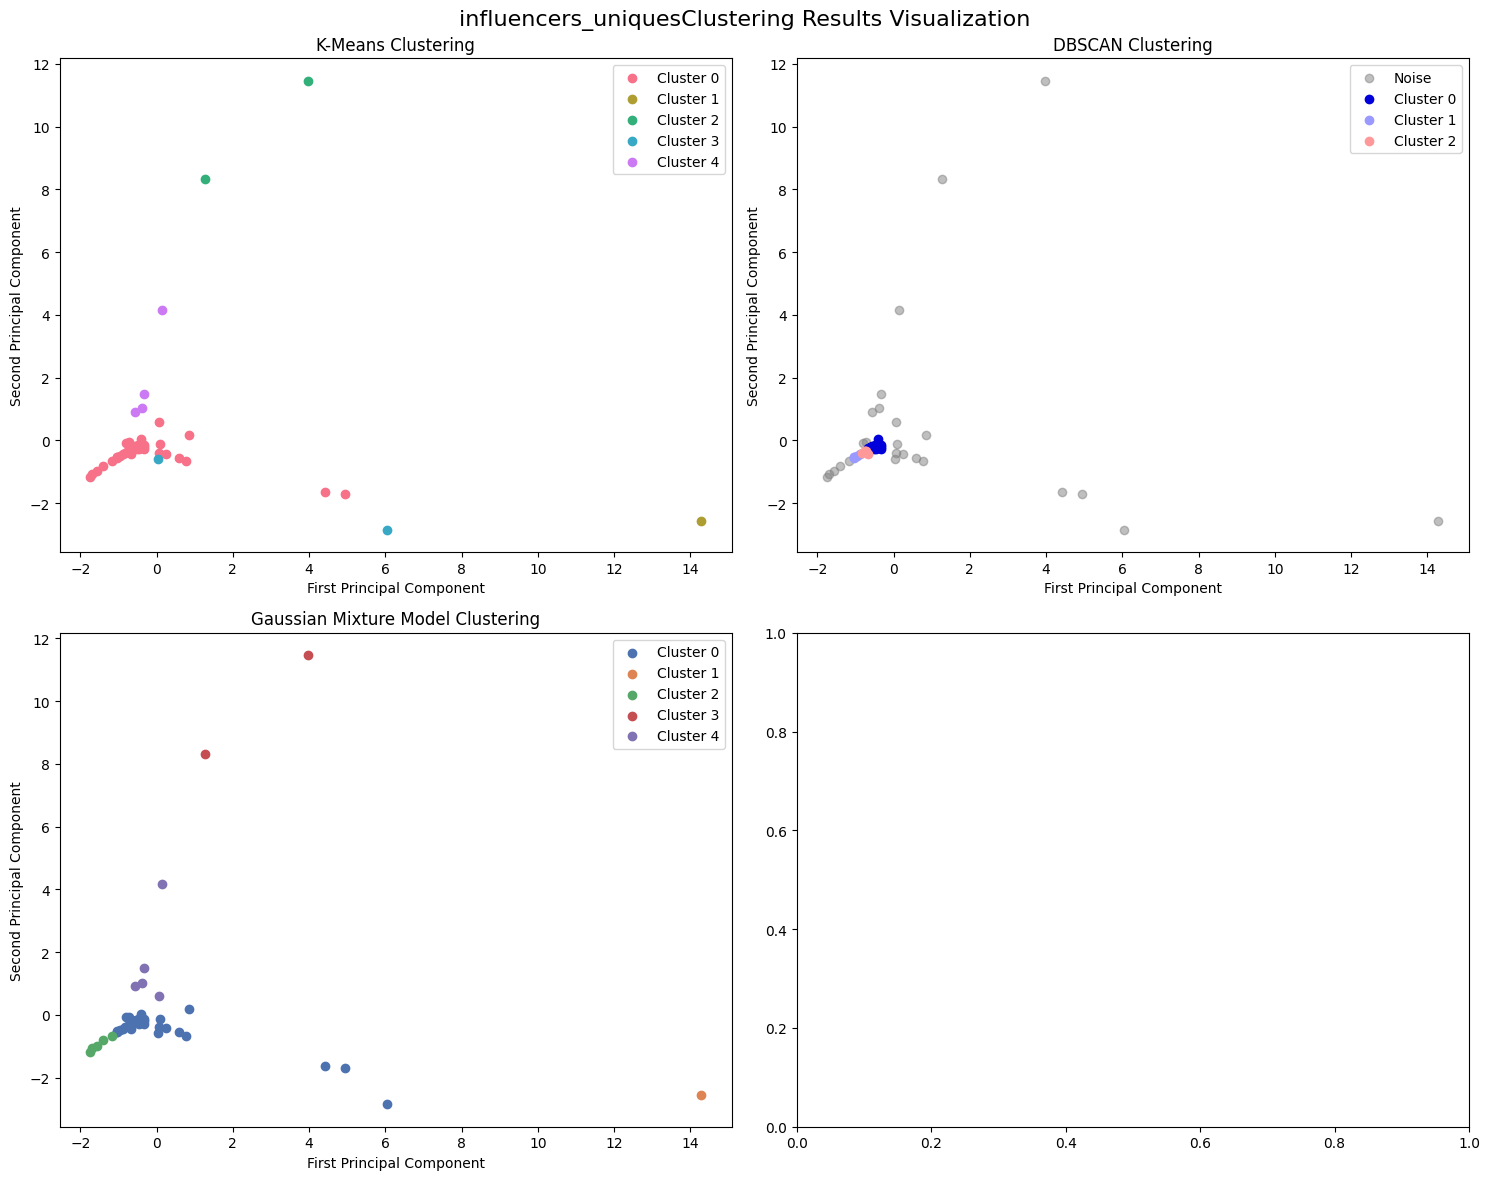


=== Clustering Metrics ===

KMEANS Clustering Metrics:
Silhouette Score: 0.6376780741465401
Davies-Bouldin Score: 0.5113265774489344
Adjusted Rand Score: 0.14470442474521825

Cluster Sizes:
Cluster 0: 61 points
Cluster 1: 1 points
Cluster 2: 2 points
Cluster 3: 2 points
Cluster 4: 4 points

DBSCAN Clustering Metrics:
Silhouette Score: 0.7207118093954339
Davies-Bouldin Score: 0.5070785208470934
Adjusted Rand Score: 0.20730157144205202

Cluster Sizes:
Cluster 0: 35 points
Cluster 1: 5 points
Cluster 2: 5 points

GMM Clustering Metrics:
Silhouette Score: 0.5931652525456274
Davies-Bouldin Score: 0.5371949424692876
Adjusted Rand Score: 0.125015511014453

Cluster Sizes:
Cluster 0: 57 points
Cluster 1: 1 points
Cluster 2: 5 points
Cluster 3: 2 points
Cluster 4: 5 points

PCA Explained Variance Ratio:
PC1: 18.42%
PC2: 13.88%
PC3: 9.48%
PC4: 7.78%
PC5: 7.26%
Total Variance Explained (first 10 PCs): 56.82%


In [193]:
#implementing the algoritms in a part of uniques, the first 50 rows
results_influencers_uniques = clustering_pipeline_all(Influencers_uniques,  pca_data_name='pca_data_influencers_uniques',
                                                  n_clusters=5, eps=0.5, min_samples=5, n_components=5)
#Calling the function for visualisation
visualize_clustering_results(results_influencers_uniques, title_prefix='influencers_uniques')
print_clustering_metrics(results_influencers_uniques)

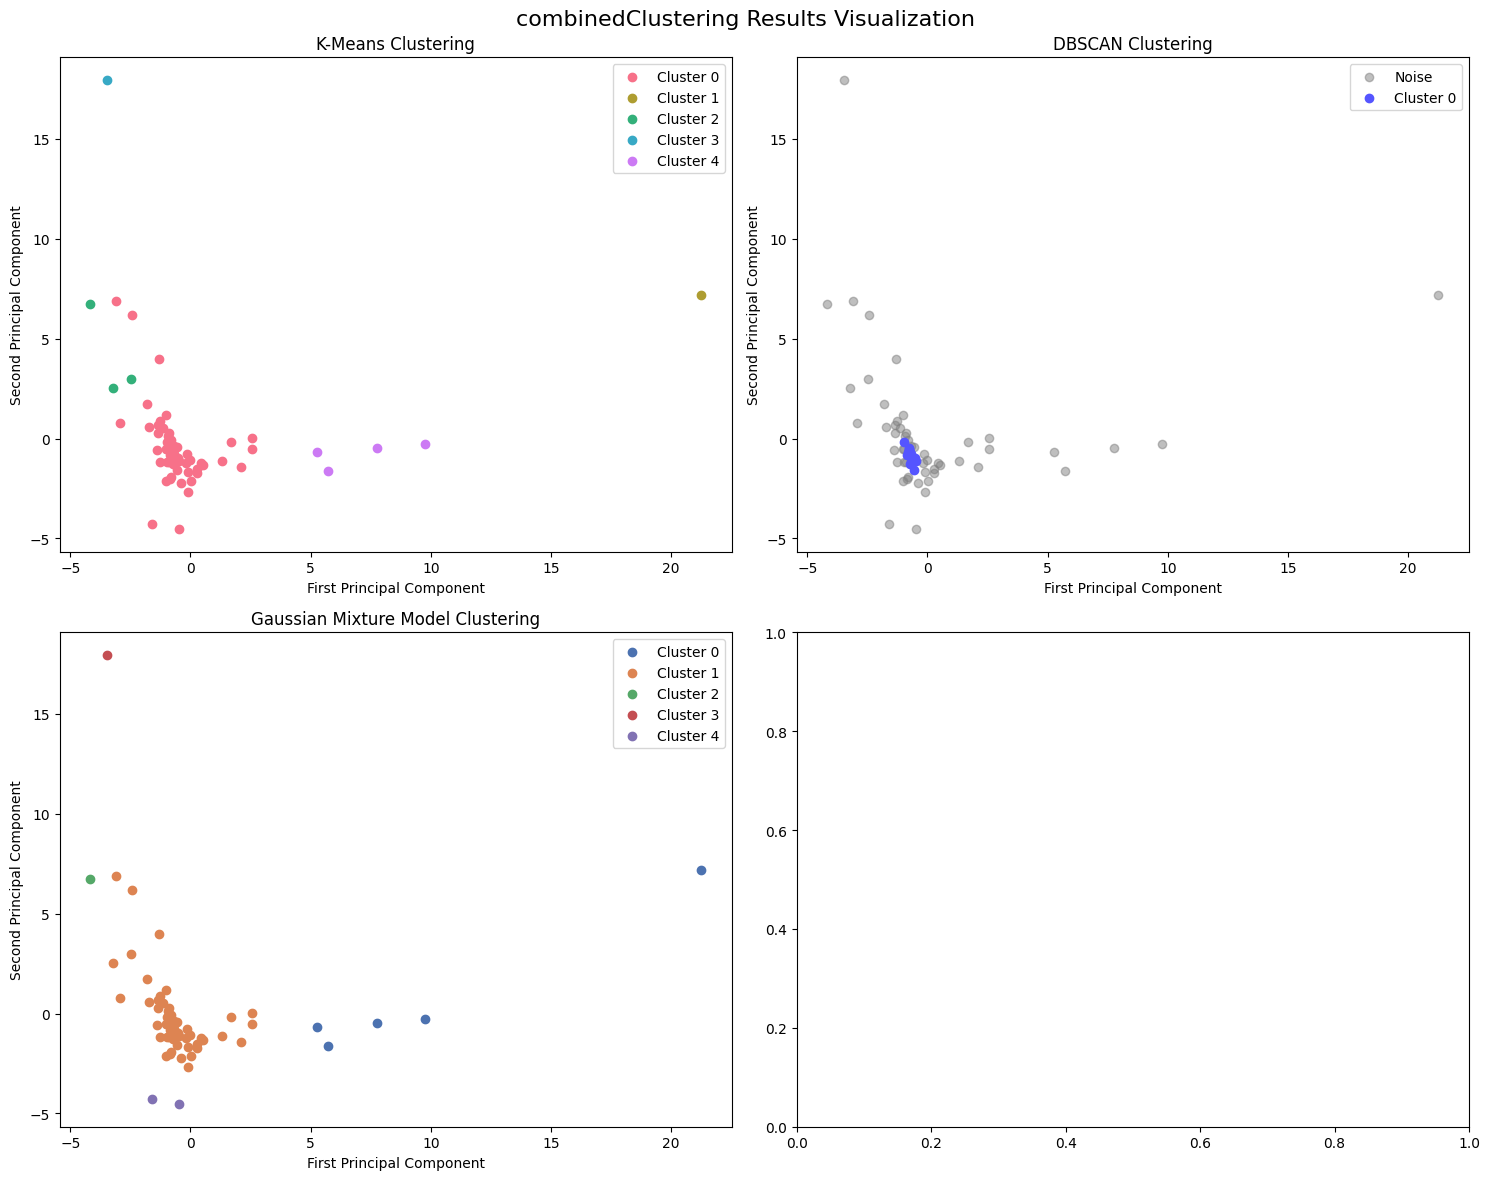


=== Clustering Metrics ===

KMEANS Clustering Metrics:
Silhouette Score: 0.6287518328099946
Davies-Bouldin Score: 0.5039965936201791
Adjusted Rand Score: 0.06266736417467424

Cluster Sizes:
Cluster 0: 61 points
Cluster 1: 1 points
Cluster 2: 3 points
Cluster 3: 1 points
Cluster 4: 4 points

DBSCAN Clustering Metrics:
Silhouette Score: Not applicable
Davies-Bouldin Score: Not applicable
Adjusted Rand Score: -0.010313174587989244

Cluster Sizes:
Cluster 0: 16 points

GMM Clustering Metrics:
Silhouette Score: 0.6531684117511438
Davies-Bouldin Score: 0.7234065699603681
Adjusted Rand Score: 0.017334275173332393

Cluster Sizes:
Cluster 0: 5 points
Cluster 1: 61 points
Cluster 2: 1 points
Cluster 3: 1 points
Cluster 4: 2 points

PCA Explained Variance Ratio:
PC1: 8.12%
PC2: 6.64%
PC3: 6.54%
PC4: 5.52%
PC5: 4.18%
Total Variance Explained (first 10 PCs): 31.01%


In [194]:
#implementing the algoritms in a part of uniques, the first 50 rows
# Running pipeline 
results_combined = clustering_pipeline_all(combined,  pca_data_name='pca_data_combined',
                                                  n_clusters=5, eps=0.5, min_samples=5, n_components=5)
#Calling the function for visualisation
visualize_clustering_results(results_combined, title_prefix='combined')
print_clustering_metrics(results_combined)

In [195]:
import plotly.graph_objects as go
from sklearn.preprocessing import LabelEncoder

# Transform scaled data using PCA
pca_transformed = pca_data.transform(scaled_data)

# Extract PCA dimensions
pc1 = pca_transformed[:, 0]
pc2 = pca_transformed[:, 1]
pc3 = pca_transformed[:, 2]

# Encode category labels if they are non-numeric
category_labels = Influencers_OLS['Category'].values
if category_labels.dtype.kind not in 'iuf':  # Check if labels are not numeric
    category_labels = LabelEncoder().fit_transform(category_labels)

# Create a 3D scatter plot
fig = go.Figure(data=[
    go.Scatter3d(
        x=pc1,
        y=pc2,
        z=pc3,
        mode='markers',
        marker=dict(
            size=5,
            color=category_labels,  # Set color to the category labels
            colorscale='Viridis',   # Choose a color scale
            opacity=0.8
        ),
        text=Influencers_OLS['Category'],  # Optional: Hover text
    )
])

# Set plot title and axis labels
fig.update_layout(
    title='Interactive 3D PCA Visualization',
    scene=dict(
        xaxis_title='PCA Dimension 1',
        yaxis_title='PCA Dimension 2',
        zaxis_title='PCA Dimension 3'
    ))

# Show the plot
fig.show()

uniques_23_OLS_50 (50 features):
K-means: Silhouette Score improved to 0.754, Davies-Bouldin reduced to 0.298
Cluster sizes even more imbalanced (44, 1, 3, 1, 1 points)
PCA explains 49.17% of variance (29.93% PC1, 19.24% PC2)

In general uniques_23_OLS_50 shows the highest explained variance (49.17%),
uniques_23_OLS_50 has the best K-means metrics:
Highest Silhouette Score (0.754)
Lowest Davies-Bouldin Score (0.298)
However upon inspection of the influencers_OLS with the clusters associated to the label on the PCA_RF_FImportance notebook, there is a consistent pattern and it is possible to distinguish three different regions on the exact place the categories are.  category 1 is a v shape that is intop of cat 2 which is in the middle and 3 form a lineal regression bewen 1 and 2 pca, so together form a y shape. it has a clear differenciation and I can see that cluster 1 is same as cat 3, cluster 2, 3 and 0 are cat 1 and that cluster 4 is cat 2. with no visual overlappings, unlikely with my labels which got at the end of the regression line of 3 an overlaping with the shape of the v. So if we were to distribute the cluster in this fashion, would be possible to say that the clustering is revealing consistent groupings that align with the original categorization:  

Category 1: Comprises clusters 0, 2, 3  (total 7 points)  
Category 2: Corresponds to cluster 4    (10 points)  
Category 3: Matches cluster 1           (53 points)  
The fact that there is a persistent structure on the shapes of all the dataframes 

Ultimately PCA primarily captures linear variance and might not effectively group data by absolute values. It's more about capturing directional variance and relationships rather than precise value clustering. The method projects data onto principal components that maximize variance, which doesn't necessarily mean it's capturing granular value-based distinctions


the principal components are mathematical combinations of the original features. It is possible to try to "invert" the PCA transformation to understand which original features are most responsible for the observed clustering patterns.
One approach would be to examine the PCA loading vectors or the contribution of each feature to the principal components. This could help identify the key underlying characteristics that are driving the separation of the data points. Moreover the cluster boundaries identified by the clustering algorithms are not fixed, static regions. They depend on the distribution of the data points and the specific parameters of the clustering methods. This means that the cluster assignments for individual data points may change if the clustering is performed again with different parameters or on a different dataset. The clustering results provide insights into the overall structure of the data, but the specific cluster boundaries are not guaranteed to be static or definitive.

The PCA loading vectors represent the coefficients that define each principal component. They indicate the relative importance or contribution of each original feature to the corresponding principal component.
By analyzing the loading vectors, it is possible to understand which of the original features are most influential in driving the separation of the data points along the different principal components. Which is very combinient because I am about to decide the selected data from each one of the dfs Influencers_OLS, OLS_all and uniques_23_OLS. By loading the vectors and identifying the original variables that more contribute to the separation, it would help with the selection of the selected genera to implement the cross examination with the physicochemical variables. With this loadings dataframe it is possible to  analyse the relationship with the original features across the principal components, by: higher absolute values = feature importance or features that contrute the most to the separation of the data points. By understand the dimension of the PCAs, then similar loading size hint similar aspects of the data or sinergistic effects?. By connecting clusters loading vectors to the clustering patterns and features, to know which are the most relevant features. 

In [196]:
def calculate_and_analyze_pca_loadings(df, pca, scaled_data_key, output_prefix):
    """
    Calculate and analyze PCA loadings for a given dataset.
    
    Parameters:
    df (pandas.DataFrame): The original DataFrame.
    pca (sklearn.decomposition.PCA): The PCA object from a previous analysis.
    scaled_data_key (str): The key in the results dictionary that holds the scaled data.
    output_prefix (str): A prefix for the output variables to ensure uniqueness.
    
    Returns:
    A dictionary containing the following keys:
    - f"{output_prefix}_loadings_df": The DataFrame of loading vectors.
    - f"{output_prefix}_top_loadings": A dictionary of top contributors for each principal component.
    """
    # Get the loading vectors
    loadings = pca.components_.T
    
    # Create a DataFrame with the loading vectors
    loadings_df = pd.DataFrame(loadings, 
                              index=df.columns[1:], 
                              columns=[f'PC{i+1}' for i in range(loadings.shape[1])])
       
    # Identify top contributors to each principal component
    def get_top_loadings(loadings_df, n_top=10):
        top_loadings = {}
        for col in loadings_df.columns:
            top_loadings[col] = loadings_df[col].abs().nlargest(n_top)
        return top_loadings
    
    top_loadings = get_top_loadings(loadings_df)
    
    # Store the results in a dictionary
    results = {
        f"{output_prefix}_loadings_df": loadings_df,
        f"{output_prefix}_top_loadings": top_loadings
    }
    
    return results

### Heatmap visualisation for PCA loadings
Here the relationships between features and components are visualised and highlight the absolute values of the loading vectors, as they represent the magnitude of feature contributions.

In [197]:
def plot_top_pca_loadings(top_loadings, output_prefix):
    """
    Create a heatmap visualization for the top PCA loadings.
    
    Parameters:
    - top_loadings (dict): A dictionary where the keys are the principal component names
                          and the values are Series containing the top contributing features.
    - output_prefix (str): A prefix for the output file name.
    """
    # Convert the top_loadings dictionary to a DataFrame
    top_loadings_df = pd.concat([loadings.rename(pc) for pc, loadings in top_loadings.items()], axis=1)
    
    # Ensure proper labels and formatting
    top_loadings_df.index.name = 'Feature'
    top_loadings_df.columns.name = 'Principal Component'
    
    # Plot a heatmap for top loadings
    plt.figure(figsize=(8, 6))
    sns.heatmap(top_loadings_df,annot=True, cmap="coolwarm", center=0, cbar_kws={'label': 'Loading Magnitude'})
    plt.title("Top PCA Loadings (10 Features per Component)")
    plt.xlabel("Principal Components")
    plt.ylabel("Top Contributing Features")
    plt.tight_layout()
    plt.savefig(f"{output_prefix}_top_pca_loadings.png", dpi=300)
    plt.show()

Calling the function to calculate and analyse the pca loadings for the dfs
## Pca Loadings for the dfs

Explained Variance Ratio: [0.19122825 0.1640954  0.10924184 0.0915163  0.06725806]
Cumulative Variance Ratio: [0.19122825 0.35532365 0.46456549 0.55608179 0.62333985]

Loading Vectors:
        PC1     PC2     PC3     PC4     PC5
725  0.3852  0.0133  0.0778  0.0580 -0.1560
871 -0.0639  0.4981  0.2586 -0.1095  0.0013
214 -0.0865 -0.1238  0.2747  0.1622 -0.4173
351  0.2767 -0.0060  0.0575 -0.0500  0.0493
23   0.4812  0.0266  0.1047  0.0583 -0.0191
91  -0.0051  0.2152 -0.2902  0.3076  0.1107
863  0.2320  0.0445 -0.1318  0.0041  0.2558
526 -0.0764 -0.1041  0.1865  0.0501 -0.5566
584 -0.0601 -0.0832  0.1729  0.0905 -0.2839
712 -0.0642  0.4990  0.2570 -0.1063  0.0000

Top Contributors to Principal Components:

PC1 Top Contributors:
23    0.4812
565   0.4489
864   0.4102
725   0.3852
351   0.2767
375   0.2663
863   0.2320
229   0.0957
214   0.0865
526   0.0764
Name: PC1, dtype: float64

PC2 Top Contributors:
712   0.4990
871   0.4981
625   0.4972
549   0.2934
91    0.2152
334   0.1610
678   0.

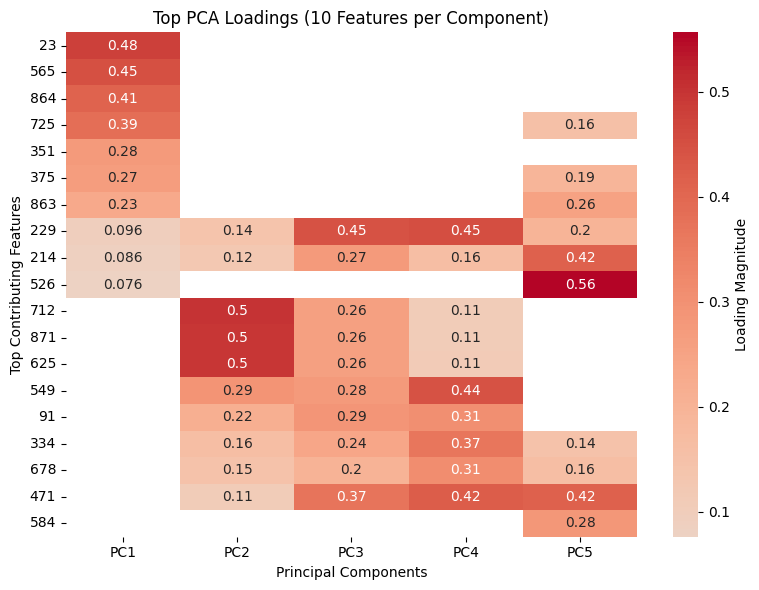

In [198]:
# We taking the data from the previous algoritms results
pca = results_Influencers_OLS['pca']
scaled_data = results_Influencers_OLS['scaled_data']
# Loadings calculation call
results_Influencers_Loadings = calculate_and_analyze_pca_loadings(Influencers_OLS, pca, 'scaled_data', 'Influencers_OLS')

# Access the results
loadings_df = results_Influencers_Loadings['Influencers_OLS_loadings_df']
explained_variance = results_Influencers_OLS['explained_variance']
cumulative_variance = results_Influencers_OLS['cumulative_variance']
top_loadings = results_Influencers_Loadings['Influencers_OLS_top_loadings']

# Print or analyze the results
print("Explained Variance Ratio:", explained_variance)
print("Cumulative Variance Ratio:", cumulative_variance)
print("\nLoading Vectors:")
print(loadings_df.head(10))
print("\nTop Contributors to Principal Components:")
for pc, loadings in top_loadings.items():
    print(f"\n{pc} Top Contributors:")
    print(loadings)

# Visualising the loadings on a simple heatmap
plot_top_pca_loadings(results_Influencers_Loadings['Influencers_OLS_top_loadings'],'Influencers_OLS')

Top contributors for PC1 and PC2 are seen. These contributions suggest which original variables drive the variance along each principal axis. Loading values indicate the weight or influence of a feature on a principal component. In for Influencers_OLS feature 23 contributes 0,48 to PC1 and feature 712 contributes 0.499 to PC2.
When puting 7 components the total explained variance ratio of the first 7 PCs is 74.19%.
Strong contribution from PC1 to PC3. Cumulative explained variance achieves a balance of high dimensionality reduction with a reasonable representation. Total explained variance ratio of the first 7 PCs is 68.38%.
Reduced explained variance suggests the additional features do not significantly improve variance representation. In fact, they dilute the strength of the first PCs.

Explained Variance Ratio: [0.18418311 0.13881821 0.09477534 0.07775328 0.072638  ]
Cumulative Variance Ratio: [0.18418311 0.32300132 0.41777666 0.49552994 0.56816794]

Loading Vectors:
        PC1     PC2     PC3     PC4     PC5
725  0.3255 -0.1359 -0.0413  0.2059  0.1069
871  0.0966  0.4862  0.1379  0.1118 -0.0530
214 -0.0760 -0.0598  0.2759  0.0257  0.1729
351  0.2423 -0.0823  0.0528 -0.1343 -0.0629
23   0.4177 -0.1283  0.0371 -0.0432  0.0636
91   0.0178  0.1610 -0.2532 -0.2193  0.2113
863  0.1762 -0.0499 -0.1302 -0.1574 -0.0706
526 -0.0685 -0.0505  0.2036  0.0180  0.0672
584 -0.0568 -0.0444  0.2169  0.0200  0.1377
712  0.0975  0.4879  0.1377  0.1107 -0.0504

Top Contributors to Principal Components:

PC1 Top Contributors:
23    0.4177
565   0.4154
541   0.3877
864   0.3487
725   0.3255
494   0.2775
351   0.2423
375   0.1934
863   0.1762
712   0.0975
Name: PC1, dtype: float64

PC2 Top Contributors:
712   0.4879
871   0.4862
625   0.4849
494   0.2798
549   0.2271
91    0.1610
725   0.

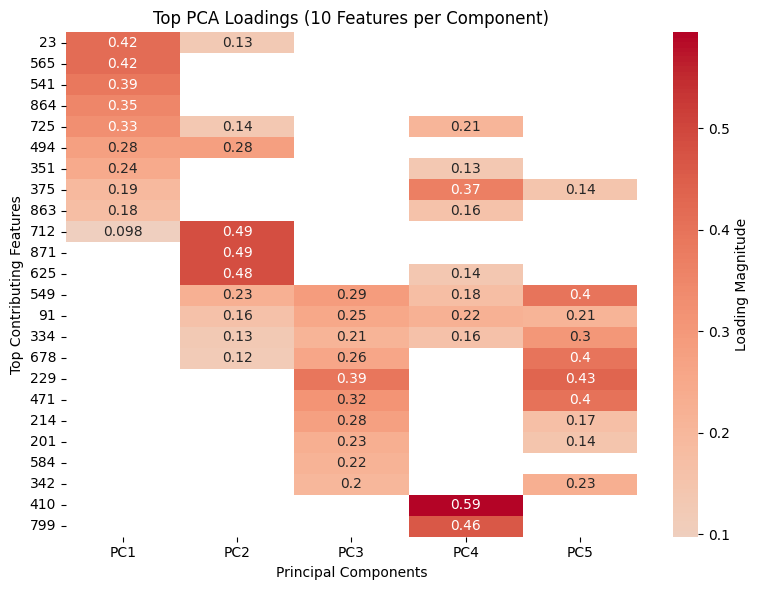

In [199]:
# We taking the data from the previous algoritms results
pca = results_influencers_uniques['pca']
scaled_data = results_influencers_uniques['scaled_data']
# Loadings calculation call
results_influencers_uniques_Loadings = calculate_and_analyze_pca_loadings(Influencers_uniques, pca, 'scaled_data', 'Influencers_uniques')

# Access the results
loadings_df = results_influencers_uniques_Loadings['Influencers_uniques_loadings_df']
explained_variance = results_influencers_uniques['explained_variance']
cumulative_variance = results_influencers_uniques['cumulative_variance']
top_loadings = results_influencers_uniques_Loadings['Influencers_uniques_top_loadings']

# Print or analyze the results
print("Explained Variance Ratio:", explained_variance)
print("Cumulative Variance Ratio:", cumulative_variance)
print("\nLoading Vectors:")
print(loadings_df.head(10))
print("\nTop Contributors to Principal Components:")
for pc, loadings in top_loadings.items():
    print(f"\n{pc} Top Contributors:")
    print(loadings)

# Visualising the loadings on a simple heatmap
plot_top_pca_loadings(results_influencers_uniques_Loadings['Influencers_uniques_top_loadings'],'Influencers_uniques')

Explained Variance Ratio: [0.13396565 0.11837093 0.10092034 0.09149917 0.08097643]
Cumulative Variance Ratio: [0.13396565 0.25233658 0.35325692 0.44475608 0.52573251]

Loading Vectors:
        PC1     PC2     PC3     PC4     PC5
140  0.0681 -0.0998  0.2964 -0.0216  0.1530
575  0.1032 -0.0043 -0.0674 -0.2632  0.1652
687  0.0850 -0.1164  0.3295 -0.0455  0.1614
465 -0.0518  0.0101 -0.0884  0.2021  0.2099
300  0.0463 -0.1236  0.3577  0.0128  0.1289
529 -0.0910  0.2019  0.0702 -0.0284 -0.0374
609  0.0966  0.0020 -0.0574 -0.1961  0.1158
564 -0.1483  0.3395  0.1131  0.0326  0.1242
250  0.3263  0.1057  0.1029  0.1200 -0.0299
474  0.0181 -0.0752  0.1791  0.0139  0.0106

Top Contributors to Principal Components:

PC1 Top Contributors:
413   0.3386
546   0.3384
265   0.3374
720   0.3310
250   0.3263
512   0.3243
44    0.2722
145   0.2000
564   0.1483
13    0.1366
Name: PC1, dtype: float64

PC2 Top Contributors:
13    0.3502
187   0.3470
736   0.3470
662   0.3468
564   0.3395
727   0.3012
529   0.

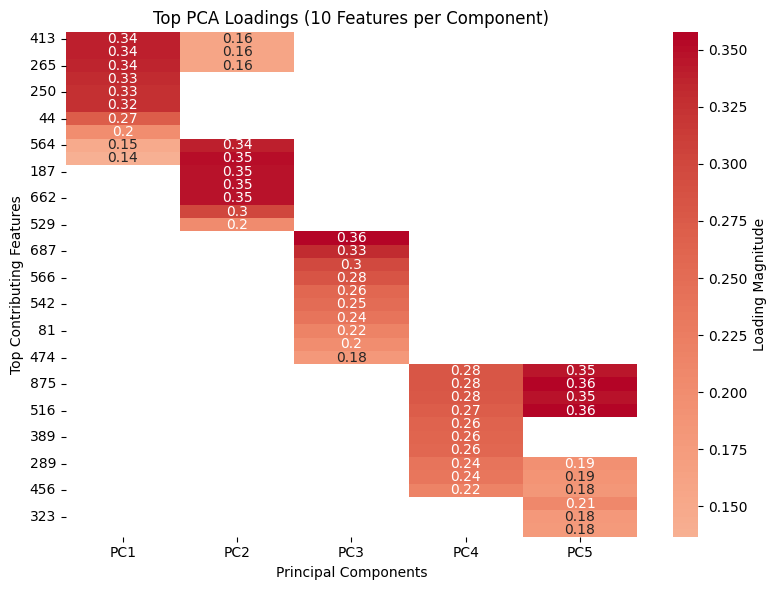

In [200]:
# We taking the data from the previous algoritms results
pca = results_original_pca['pca']
scaled_data = results_original_pca['scaled_data']
# Loadings calculation call
results_original_pca_Loadings = calculate_and_analyze_pca_loadings(original_pca, pca, 'scaled_data', 'original_pca')

# Access the results
loadings_df = results_original_pca_Loadings['original_pca_loadings_df']
explained_variance = results_original_pca['explained_variance']
cumulative_variance = results_original_pca['cumulative_variance']
top_loadings = results_original_pca_Loadings['original_pca_top_loadings']

# Print or analyze the results
print("Explained Variance Ratio:", explained_variance)
print("Cumulative Variance Ratio:", cumulative_variance)
print("\nLoading Vectors:")
print(loadings_df.head(10))
print("\nTop Contributors to Principal Components:")
for pc, loadings in top_loadings.items():
    print(f"\n{pc} Top Contributors:")
    print(loadings)

# Visualising the loadings on a simple heatmap
plot_top_pca_loadings(results_original_pca_Loadings['original_pca_top_loadings'],'original_pca')

Explained Variance Ratio: [0.08121835 0.0664213  0.06541981 0.05521543 0.0418443 ]
Cumulative Variance Ratio: [0.08121835 0.14763964 0.21305945 0.26827488 0.31011918]

Loading Vectors:
        PC1     PC2     PC3     PC4     PC5
649 -0.0170 -0.0269  0.0443 -0.0124  0.0282
585  0.0368 -0.0074 -0.0068  0.0043 -0.0386
574  0.1945  0.2016 -0.0667 -0.0852  0.0412
771  0.0934 -0.0224  0.0434  0.1641  0.0657
526 -0.0125 -0.0104 -0.0170 -0.0099 -0.0287
242  0.0371  0.0069  0.0835  0.0973 -0.0058
201 -0.0051 -0.0601 -0.0233 -0.0111  0.1546
558  0.2442  0.0563  0.0114 -0.0134  0.0193
240 -0.0365  0.2309 -0.0960  0.0888  0.0914
578 -0.0071 -0.0050  0.0070  0.0091 -0.0267

Top Contributors to Principal Components:

PC1 Top Contributors:
564   0.2451
166   0.2448
558   0.2442
660   0.2400
733   0.2398
227   0.2394
270   0.2335
639   0.2235
367   0.2235
584   0.2235
Name: PC1, dtype: float64

PC2 Top Contributors:
529   0.2362
79    0.2323
427   0.2309
132   0.2309
240   0.2309
635   0.2309
549   0.

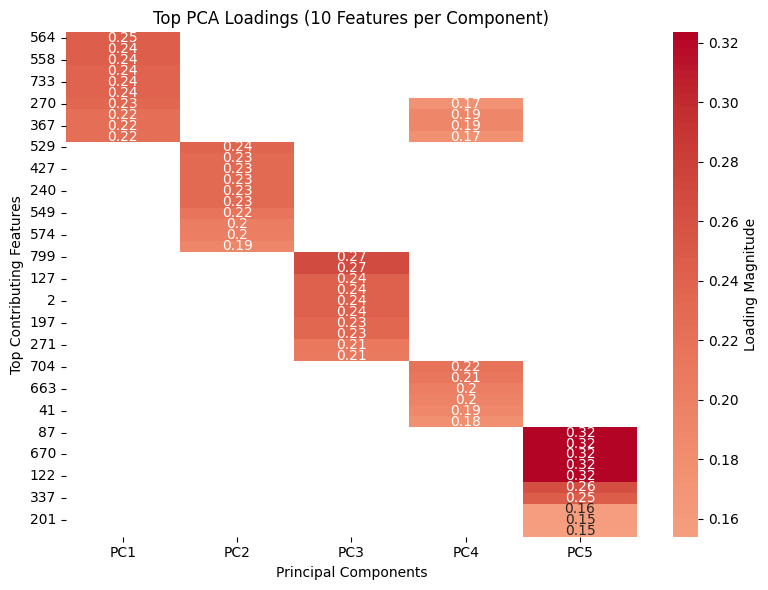

In [201]:
# We taking the data from the previous algoritms results
pca = results_combined['pca']
scaled_data = results_combined['scaled_data']
# Loadings calculation call
results_combined_Loadings = calculate_and_analyze_pca_loadings(combined, pca, 'scaled_data', 'combined')

# Access the results
loadings_df = results_combined_Loadings['combined_loadings_df']
explained_variance = results_combined['explained_variance']
cumulative_variance = results_combined['cumulative_variance']
top_loadings = results_combined_Loadings['combined_top_loadings']

# Print or analyze the results
print("Explained Variance Ratio:", explained_variance)
print("Cumulative Variance Ratio:", cumulative_variance)
print("\nLoading Vectors:")
print(loadings_df.head(10))
print("\nTop Contributors to Principal Components:")
for pc, loadings in top_loadings.items():
    print(f"\n{pc} Top Contributors:")
    print(loadings)

# Visualising the loadings on a simple heatmap
plot_top_pca_loadings(results_combined_Loadings['combined_top_loadings'],'combined')

#### Adjusted Rand Index (ARI):
Here the quality of clustering (e.g., KMeans) is evaluated against true labels. ARI measures agreement between predicted and true clusters, adjusting for chance. As said previously the clusters seem to be linked to the categories as pca notbeokk so we going to map the back and try the index again

In [207]:
# Cluster-to-category mapping 
cluster_to_category = {
    0: 3,  # Cluster 0 → Category 3
    1: 1,  # Cluster 2 → Category 1
    2: 1,  # Cluster 3 → Category 1
    3: 1,  # Cluster 4 → Category 2
    4: 2   # Cluster 1 → Category 3
}

# Apply mapping to predicted cluster labels
mapped_labels = np.array([cluster_to_category[label] for label in results_Influencers_OLS['kmeans']['cluster_labels']]) #kmean, dbscan,

# Recalculate ARI
true_labels = Influencers_OLS['Category']
adjusted_ari = adjusted_rand_score(true_labels, mapped_labels)
print(f"Adjusted ARI after remapping: {adjusted_ari}")

Adjusted ARI after remapping: 0.1886182278697579


## t-SNE for Visualization
t-SNE is a non-linear dimensionality reduction technique that is particularly effective for visualizing high-dimensional data in 2D or 3D. It often preserves local structure better than PCA

In [226]:
def tsne_visualization(scaled_data):
    """
    Visualizes data using t-SNE.
    
    Parameters:
    - df: Scaled DataFrame or numpy array (features only).
    - labels: Cluster or category labels to color-code.
    - perplexity: Perplexity for t-SNE (default=30).
    - n_components: Number of components for t-SNE (default=2).
    - random_state: Random seed for reproducibility.
    """
    # Apply t-SNE
    tsne = TSNE(n_components=3, perplexity=30, random_state=42)
    tsne_results = tsne.fit_transform(scaled_data)

    # Plot t-SNE results
    plt.figure(figsize=(8, 6))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=true_labels, cmap='viridis', s=50, alpha=0.7)
    plt.colorbar(label='True Labels')
    plt.title("t-SNE Visualization")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



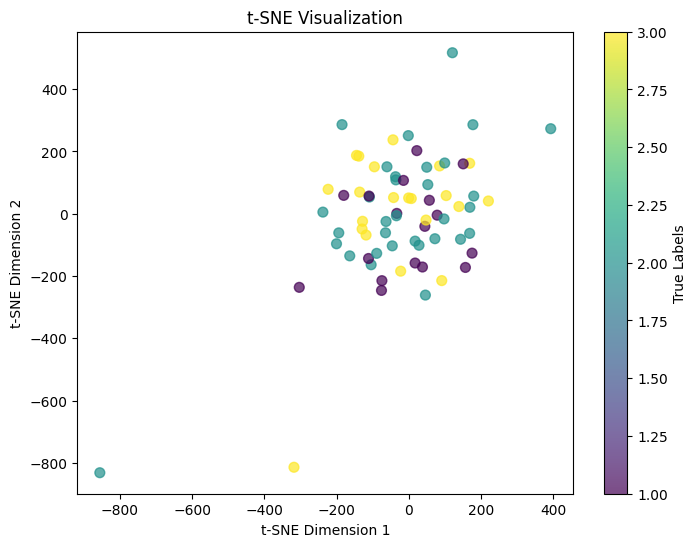

In [227]:
# Visualising the implementation
scaled_data = results_Influencers_OLS['scaled_data']
tsne_visualization(scaled_data)

## UMAP for Visualization
UMAP (Uniform Manifold Approximation and Projection) is another excellent method for non-linear dimensionality reduction.

In [228]:
def umap_visualization(df, scaled_data, label_column='Category', n_neighbors=10, min_dist=0.1, colors=None):
    """
    Visualizes data using UMAP with custom colors.

    Parameters:
    - scaled_data: Scaled DataFrame or numpy array (features only).
    - labels: Cluster or category labels for color-coding.
    - categories: List of category values to match labels.
    - colors: List of colors corresponding to each category.
    - n_neighbors: Number of neighbors for UMAP (default=15).
    - min_dist: Minimum distance between points (default=0.1).
    
    Returns:
    - None (Displays a plot)
    """
    # Get category labels from the DataFrame
    labels = df[label_column].values

    # Apply UMAP
    umap_reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=2, random_state=42)
    umap_results = umap_reducer.fit_transform(scaled_data)

    # Create a mapping from labels to colors
    label_color_map = {category: color for category, color in zip(categories, colors)}
    mapped_colors = [label_color_map[label] for label in labels]
   
    plt.figure(figsize=(8, 6))
    plt.scatter(
        umap_results[:, 0], umap_results[:, 1],
        c=mapped_colors, alpha=0.8, s=50
    )
    plt.title('UMAP Visualization with Custom Colors')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    # Plotting

    # Add legend
    handles = [plt.Line2D([0], [0], marker='o', color=color, linestyle='', markersize=10, label=f'Category {category}')
               for category, color in zip(categories, colors)]
    plt.legend(handles=handles, title='Category', loc='best')

    plt.show()

In [229]:
scaled_data = results_Influencers_OLS['scaled_data']
# Extract category labels
category_labels = Influencers_OLS['Category'].values
categories = [1, 2, 3]  # categories in the data
colors = ['green', 'orange', 'red']  
        

# Calling the function
umap_visualization(Influencers_OLS, scaled_data, label_column='Category', colors=colors)

NameError: name 'umap' is not defined

In [ ]:
https://www.nature.com/articles/s41529-022-00218-4#data-availability

# Microbiological Analysis Compendium

## Study Context
This study focuses on understanding microbial community structures through advanced statistical and machine learning techniques, specifically examining bacterial genera across different environmental conditions.

## Datasets
### Primary Datasets
1. **Influencers_OLS**: 
   - Filtered data with genera above 0.2% abundance
   - Minimum frequency of 3
   - Selected using Ordinary Least Squares (OLS)

2. **OLS_all**: 
   - Comprehensive dataset with significance selection by OLS

3. **uniques_23_OLS**:
   - Includes unique genera samples
   - Incorporates common genera from categories 2 and 3
   - Underwent OLS significance selection

## Methodological Approach

### Dimensionality Reduction
- **Principal Component Analysis (PCA)**
  - Reduced dataset to principal components
  - Retained approximately 90% of variance
  - Transformed high-dimensional microbiological data

### Clustering Techniques
1. **K-Means Clustering**
   - Fixed number of clusters (5)
   - Identified underlying data structures

2. **DBSCAN**
   - Density-based spatial clustering
   - Detected clusters and potential outliers

3. **Gaussian Mixture Models (GMM)**
   - Captured potential non-linear data structures

## Performance Metrics

### Clustering Evaluation
- **Silhouette Score**: Measures cluster cohesion
- **Davies-Bouldin Index**: Assesses cluster separation
- **Adjusted Rand Index (ARI)**: Compared clustering results with original categories

### Key Performance Insights
- Highest performing dataset: uniques_23_OLS_50
  - Silhouette Score: 0.754
  - Davies-Bouldin Score: 0.298
  - Explained Variance: 49.17%

## Visualization Techniques
1. **PCA Scatter Plots**
2. **t-SNE Visualization**
3. **UMAP**
4. **PCA Loadings Heatmap**

## Key Observations
- Clustering algorithms effectively captured inherent data structure
- Persistent patterns across different datasets
- Potential alignment between clustering results and original microbial categories

## Limitations and Considerations
- PCA primarily captures linear variance
- Cluster boundaries are not static
- Loadings represent feature contributions, not absolute distinctions

## Recommended Next Steps
1. Further investigation of top contributing features
2. Correlation with physicochemical parameters
3. Validation of microbial genera distribution

## Conclusion
The analysis reveals complex microbiological community structures, demonstrating the potential of advanced statistical techniques in understanding microbial ecology.